# Noise2Void - 3D Example

In [1]:
!export TF_FORCE_GPU_ALLOW_GROWTH=true

In [2]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile


Using TensorFlow backend.


# Download Example Data
Thanks to Romina Piscitello (Eaton Lab, MPI-CBG) for letting us use her data.

In [3]:
import pims
import numpy as np
import dask
import dask.array
import warnings
import cupy as cp
import glob
__author__ = """João Mamede"""
__email__ = "jmamede@rush.edu"
import sys 
sys.path.insert(0,'/home/jmamede/scripts/LivePanelize')
import Libraries

filelist = glob.glob('/home/jmamede/Data/CaRuby3/20201231/jan2020igfp3caru3_f2_vitc_pbn_nh4cl45mins_pump_004_*.tiff')
filelist.sort()

# all = []
filelist
all = Libraries.stitch(filelist,6,6)
all8 = all.map_blocks(Libraries.convert16to8bits)
#can't reshape I don't know why, resclicing was the only way I found
green = all8[:-3:3]
red = all8[1:-2:3]
blue = all8[2:-1:3]
green.shape

# (1, 35, 520, 692, 1)
# green = [dask.array.moveaxis(green, 0, -1)]
# green.shape
# green.reshape(5120,5120,119)
rgb = dask.array.stack([red,blue,green],axis=3)
rgb
# # rgb = rgb.compute()

,Array,Chunk
Bytes,6.46 GB,1.05 MB
Shape,"(57, 6144, 6144, 3)","(1, 1024, 1024, 1)"
Count,49896 Tasks,6156 Chunks
Type,uint8,numpy.ndarray


In [4]:
rgb = rgb.reshape(57,1,6144,6144,3)
# rgb = dask.array.swapaxes(rgb, 0, -1)
# rgb = dask.array.swapaxes(rgb, 0, 1)
# rgb = rgb.reshape(1,119,5120,5120,3)
# data                : list(array(float))
#                       List of images with dimensions 'SZYXC' or 'SYXC'
# green = green.reshape(1,119,5120,5120,1)
# rgb = green.reshape(119,1,5120,5120,1)

rgb.shape

(57, 1, 6144, 6144, 3)

# Training Data Preparation
For training we will load __one__ low-SNR 3D-tif-volume and use the <code>N2V_DataGenerator</code> to extract non-overlapping 3D-patches. Since N2V is a self-supervised method, we don't need targets.

In [5]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()


In [6]:

rgb = rgb[2,].compute()
# rgb = rgb[2,...]

In [7]:
rgb = [rgb]

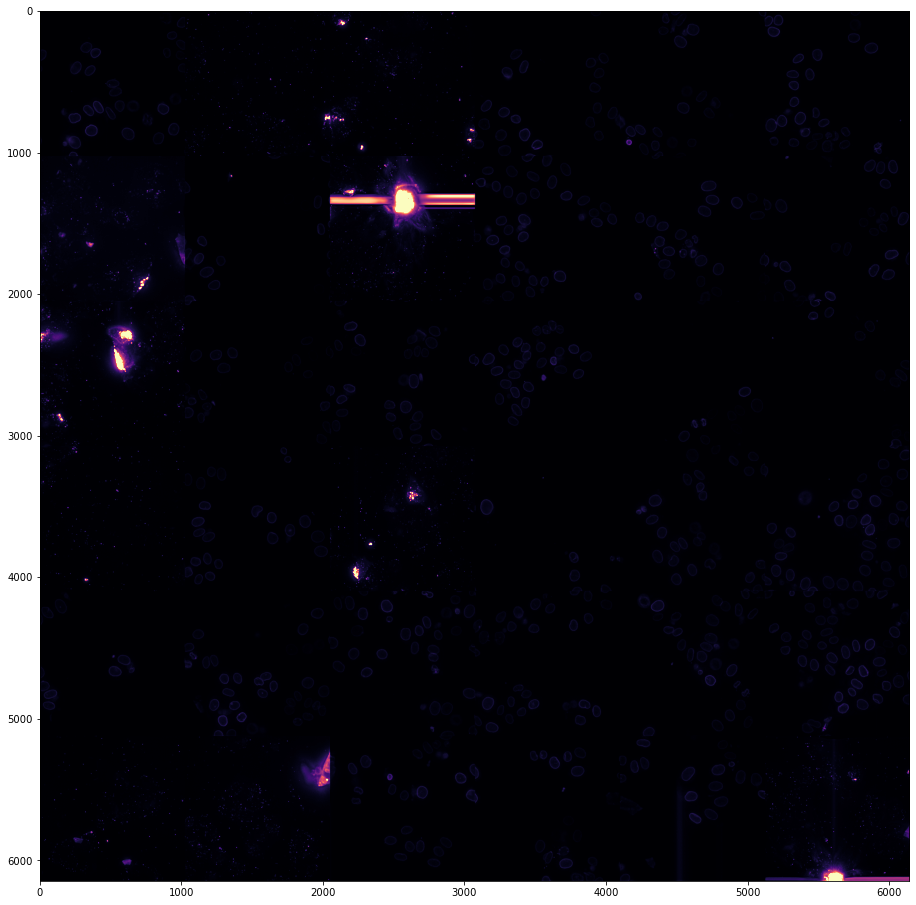

In [8]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(rgb[0][0,...,1], 
           cmap='magma',
           vmin=np.percentile(rgb[0][0,...,1],0.1),
           vmax=np.percentile(rgb[0][0,...,1],99.9)
          )
plt.show()
# rgb = list(rgb[0,:])

In [9]:
# Here we extract patches for training and validation.
patch_shape = (64, 64)
# rgb[0]
# print(img.shape)
patches = datagen.generate_patches_from_list(rgb[:1], shape=patch_shape)
                                            

Generated patches: (73728, 64, 64, 3)


In [10]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:40000]
X_val = patches[40000:]
X.shape

(40000, 64, 64, 3)

In [11]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

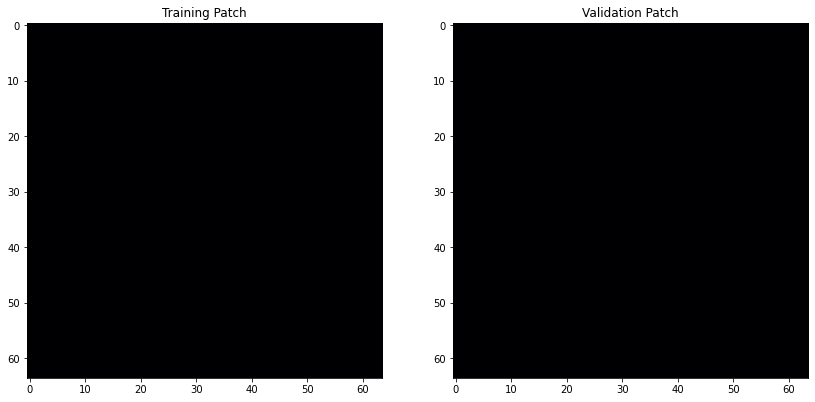

In [12]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,1],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,1],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [13]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['4.92734736328125', '1.8587403991699218', '3.393765167236328'],
 'stds': ['10.61841560054332', '9.479498570250863', '12.305920280513218'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 312,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'structN2Vmask': None,
 'probabilistic': False}

In [14]:
# a name used to identify the model
model_name = 'n2v_3D'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

/home/jmamede/anaconda3/lib/python3.7/site-packages/n2v/models/n2v_standard.py:428: UserWarning: output path for model already exists, files may be overwritten: /home/jmamede/scripts/notebooks/n2v/models/n2v_3D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training

In [ ]:

history = model.train(X, X_val)


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 33728/33728 [00:33<00:00, 1019.91it/s]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/20
312/312 [==============================] - 100s 322ms/step - loss: 0.7971 - n2v_mse: 0.7971 - n2v_abs: 0.2758 - val_loss: 1.0011 - val_n2v_mse: 1.0011 - val_n2v_abs: 0.1826

Epoch 2/20
312/312 [==============================] - 92s 295ms/step - loss: 0.6586 - n2v_mse: 0.6586 - n2v_abs: 0.2227 - val_loss: 0.1482 - val_n2v_mse: 0.1482 - val_n2v_abs: 0.1058
Epoch 3/20
312/312 [==============================] - 92s 296ms/step - loss: 0.6074 - n2v_mse: 0.6074 - n2v_abs: 0.2125 - val_loss: 0.1190 - val_n2v_mse: 0.1190 - val_n2v_abs: 0.0967
Epoch 4/20
312/312 [==============================] - 93s 299ms/step - loss: 1.3

### After training, lets plot training and validation loss.

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [ ]:
model.export_TF(name='Noise2Void - Stitched Panel', 
                description='This is the 3D Noise2Void example trained in python.', 
                authors=["Joao Mamede"],
                test_img=X_val[0,...,0], axes='TZYXC',
                patch_shape=patch_shape)